# Pytorch Lightning Framework for training S+Z Galaxy Classifiers

## Imports

In [18]:
import os
from enum import Enum
import pandas as pd
import torch
from torch.utils.data import random_split
import lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import albumentations as A
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule
from ChiralityClassifier import ChiralityClassifier

## Options

In [19]:
class modes(Enum):
    FULL_DATASET = 0 #Use all 600,000 galaxies
    CUT_DATASET = 1 #Use cut of 200,000 galaxies, with pre-selected test data and downsampled train data
    BEST_SUBSET = 2 #Select N best S,Z & other galaxies, evenly split
    LOCAL_SUBSET = 3 #Use local cache of 1500 galaxies

IMG_SIZE = 160 # This is the output size of the generated image array
MODE = modes.CUT_DATASET
RUN_TEST = False #Run on testing dataset & save metrics
# Models:
#resnet18,resnet34,resnet50,resnet101,resnet152,
#jiaresnet50,LeNet,
#G_ResNet18,G_LeNet,
MODEL_NAME = 'resnet18'
CUSTOM_ID = 'repeat'
USE_TENSORBOARD = False
SAVE_MODEL = False
REPEAT_RUNS = 5 #Set to 0 for 1 run

#MODEL_SAVE_PATH = "../Models"
#GRAPH_SAVE_PATH = "../Graphs"
METRICS_PATH = "../Metrics"
LOG_PATH = "../Code/lightning_logs"
FULL_DATA_PATH = '/share/nas2/walml/galaxy_zoo/decals/dr8/jpg'
LOCAL_SUBSET_DATA_PATH = '../Data/Subset'

FULL_CATALOG_PATH = '../Data/gz1_desi_cross_cat.csv'
CUT_CATALOG_TEST_PATH = '../Data/gz1_desi_cross_cat_testing.csv'
CUT_CATALOG_TRAIN_PATH = '../Data/gz1_desi_cross_cat_train_val_downsample.csv'
BEST_SUBSET_CATALOG_PATH = '../Data/gz1_desi_cross_cat_best_subset.csv'
LOCAL_SUBSET_CATALOG_PATH = '../Data/gz1_desi_cross_cat_local_subset.csv'

torch.set_float32_matmul_precision("medium")
MODEL_ID = f"{MODEL_NAME}_{MODE.name.lower()}_{CUSTOM_ID}"

## GPU Test

In [20]:
print(f"Using pytorch {torch.__version__}. CPU cores available on device: {os.cpu_count()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(f'Allocated Memory: {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB')
    print(f'Cached Memory: {round(torch.cuda.memory_reserved(0)/1024**3,1)} GB')
print('Using device:', device)

Using pytorch 2.2.1. CPU cores available on device: 24
NVIDIA A100-PCIE-40GB
Allocated Memory: 0.0 GB
Cached Memory: 0.0 GB
Using device: cuda


## Reading in data

### Building catalog

In [21]:
def get_file_paths(catalog_to_convert,folder_path):
    brick_ids = catalog_to_convert['dr8_id'].str.split("_",expand=True)[0]
    dr8_ids = catalog_to_convert['dr8_id']
    file_locations = folder_path+'/'+brick_ids+'/'+dr8_ids+'.jpg'
    print(f"Created {file_locations.shape[0]} galaxy filepaths")
    return file_locations

def check_folder(save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

def generate_transforms(resize_after_crop=IMG_SIZE):
    transforms_to_apply = [
        A.ToFloat(), #Converts from 0-255 to 0-1

        A.Resize( #Resizes to 160x160
            height=resize_after_crop,
            width=resize_after_crop,
            interpolation=1,
            always_apply=True
        ),

        #A.randomrotate
    ]
    return A.Compose(transforms_to_apply)

In [22]:
if MODE == modes.CUT_DATASET:
    train_val_catalog = pd.read_csv(CUT_CATALOG_TRAIN_PATH)
    train_val_catalog['file_loc'] = get_file_paths(train_val_catalog,FULL_DATA_PATH)
    generator1 = torch.Generator().manual_seed(42) #Preset test-val split, note test dataloader will still shuffle
    train_catalog, val_catalog = random_split(train_val_catalog, [0.20,0.80], generator=generator1)
    train_catalog = train_catalog.dataset.iloc[train_catalog.indices]
    val_catalog = val_catalog.dataset.iloc[val_catalog.indices]   
    test_catalog = pd.read_csv(CUT_CATALOG_TEST_PATH)
    test_catalog['file_loc'] = get_file_paths(test_catalog,FULL_DATA_PATH)

    datamodule = GalaxyDataModule(
        label_cols=['P_CW','P_ACW','P_OTHER'],
        train_catalog=train_catalog, val_catalog=train_catalog, test_catalog=test_catalog,
        custom_albumentation_transform=generate_transforms(),
        batch_size=200,
        num_workers=11,
    )
    
else:
    if MODE == modes.FULL_DATASET:
        catalog = pd.read_csv(FULL_CATALOG_PATH)
        catalog['file_loc'] = get_file_paths(catalog,FULL_DATA_PATH)

    elif MODE == modes.BEST_SUBSET:
        catalog = pd.read_csv(BEST_SUBSET_CATALOG_PATH)
        catalog['file_loc'] = get_file_paths(catalog,FULL_DATA_PATH)

    elif MODE == modes.LOCAL_SUBSET:
        catalog = pd.read_csv(LOCAL_SUBSET_CATALOG_PATH)
        catalog['file_loc'] = get_file_paths(catalog,LOCAL_SUBSET_DATA_PATH)

    datamodule = GalaxyDataModule(
        label_cols=['P_CW','P_ACW','P_OTHER'],
        catalog=catalog,
        train_fraction=0.7, val_fraction=0.15, test_fraction=0.15,
        custom_albumentation_transform=generate_transforms(),
        batch_size=100,
        num_workers=11,
    )

Created 35988 galaxy filepaths
Created 41737 galaxy filepaths


## Code to run

In [23]:
datamodule.prepare_data()
datamodule.setup()

/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | model   | ResNet           | 11.2 M
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

STAGE:2024-03-12 12:22:44 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  11%|█         | 4/36 [00:04<00:35,  1.12s/it, v_num=0, train_loss_step=0.994, train_acc_step=0.610, train_calibration_error_step=0.0426]

STAGE:2024-03-12 12:22:49 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:22:49 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#AdamW.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]ChiralityClassifier.optimizer_step (function operator())


Epoch 0: 100%|██████████| 36/36 [00:09<00:00,  3.78it/s, v_num=0, train_loss_step=0.903, train_acc_step=0.636, train_calibration_error_step=0.0648]

STAGE:2024-03-12 12:22:55 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


STAGE:2024-03-12 12:22:56 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:22:56 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 59: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s, v_num=0, train_loss_step=0.544, train_acc_step=0.990, train_calibration_error_step=0.251, val_acc=0.979, val_calibration_error=0.225, train_loss_epoch=0.531, train_acc_epoch=0.969, train_calibration_error_epoch=0.214]  

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 36/36 [00:14<00:00,  2.40it/s, v_num=0, train_loss_step=0.544, train_acc_step=0.990, train_calibration_error_step=0.251, val_acc=0.979, val_calibration_error=0.225, train_loss_epoch=0.531, train_acc_epoch=0.969, train_calibration_error_epoch=0.214]


FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         2.87%       7.665ms        99.98%     266.684ms     133.342ms       0.000us         0.00%      64.959ms      32.480ms             2  
                [pl][profile][_EvaluationLoop].val_next         0.16%     432.000us        64.17%     171.155ms      85.578ms       0.000us         0.00%       

Testing DataLoader 0:  11%|█         | 4/36 [00:00<00:04,  7.42it/s]

STAGE:2024-03-12 12:38:12 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 12:38:12 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:38:12 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Testing DataLoader 0: 100%|██████████| 36/36 [00:05<00:00,  7.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9788830280303955     │
│  test_calibration_error   │    0.22471925616264343    │
│         test_loss         │    0.5288649201393127     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         2.25%       3.803ms        98.93%     167.404ms      55.801ms       0.000us         0.00%     160.397ms      53.466ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.test_ste...         7.91%      13.386ms        92.37%     156.298ms      52.099ms       0.000us         0.00%     1

STAGE:2024-03-12 12:38:21 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  11%|█         | 4/36 [00:04<00:35,  1.12s/it, v_num=1, train_loss_step=1.160, train_acc_step=0.405, train_calibration_error_step=0.0321]

STAGE:2024-03-12 12:38:26 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:38:26 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#AdamW.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]ChiralityClassifier.optimizer_step (function operator())


Epoch 0: 100%|██████████| 36/36 [00:10<00:00,  3.48it/s, v_num=1, train_loss_step=0.993, train_acc_step=0.566, train_calibration_error_step=0.0128]

STAGE:2024-03-12 12:38:34 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 12:38:34 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:38:34 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 59: 100%|██████████| 36/36 [00:13<00:00,  2.60it/s, v_num=1, train_loss_step=0.531, train_acc_step=0.970, train_calibration_error_step=0.224, val_acc=0.978, val_calibration_error=0.225, train_loss_epoch=0.531, train_acc_epoch=0.972, train_calibration_error_epoch=0.217]  

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s, v_num=1, train_loss_step=0.531, train_acc_step=0.970, train_calibration_error_step=0.224, val_acc=0.978, val_calibration_error=0.225, train_loss_epoch=0.531, train_acc_epoch=0.972, train_calibration_error_epoch=0.217]


FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         7.09%       6.923ms        99.91%      97.538ms      48.769ms       0.000us         0.00%      65.574ms      32.787ms             2  
[pl][profile][Strategy]SingleDeviceStrategy.validati...         7.21%       7.037ms        78.54%      76.672ms      38.336ms       0.000us         0.00%      5

Testing DataLoader 0:  11%|█         | 4/36 [00:00<00:01, 17.03it/s]

STAGE:2024-03-12 12:53:55 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 12:53:56 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:53:56 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Testing DataLoader 0: 100%|██████████| 36/36 [00:04<00:00,  7.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9781883955001831     │
│  test_calibration_error   │    0.22526311874389648    │
│         test_loss         │    0.5290448069572449     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.76%       3.132ms        99.89%     177.551ms      59.184ms       0.000us         0.00%     150.332ms      50.111ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.test_ste...         4.44%       7.896ms        94.43%     167.833ms      55.944ms       0.000us         0.00%     1

STAGE:2024-03-12 12:54:05 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  11%|█         | 4/36 [00:04<00:36,  1.13s/it, v_num=2, train_loss_step=0.994, train_acc_step=0.580, train_calibration_error_step=0.0581]

STAGE:2024-03-12 12:54:09 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:54:09 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#AdamW.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]ChiralityClassifier.optimizer_step (function operator())


Epoch 0: 100%|██████████| 36/36 [00:09<00:00,  3.69it/s, v_num=2, train_loss_step=0.932, train_acc_step=0.657, train_calibration_error_step=0.0998] 

STAGE:2024-03-12 12:54:16 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


STAGE:2024-03-12 12:54:17 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 12:54:17 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 59: 100%|██████████| 36/36 [00:14<00:00,  2.57it/s, v_num=2, train_loss_step=0.534, train_acc_step=0.949, train_calibration_error_step=0.188, val_acc=0.952, val_calibration_error=0.187, train_loss_epoch=0.531, train_acc_epoch=0.969, train_calibration_error_epoch=0.213] 

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s, v_num=2, train_loss_step=0.534, train_acc_step=0.949, train_calibration_error_step=0.188, val_acc=0.952, val_calibration_error=0.187, train_loss_epoch=0.531, train_acc_epoch=0.969, train_calibration_error_epoch=0.213]


FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.94%       2.805ms        99.86%     298.217ms     149.108ms       0.000us         0.00%      65.919ms      32.959ms             2  
                [pl][profile][_EvaluationLoop].val_next         0.11%     320.000us        69.94%     208.851ms     104.425ms       0.000us         0.00%       

Testing DataLoader 0:  11%|█         | 4/36 [00:00<00:02, 13.61it/s]

STAGE:2024-03-12 13:09:17 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 13:09:17 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 13:09:17 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Testing DataLoader 0: 100%|██████████| 36/36 [00:05<00:00,  6.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9519311189651489     │
│  test_calibration_error   │    0.18726441264152527    │
│         test_loss         │    0.5324193239212036     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         3.73%       7.825ms        99.97%     209.968ms      69.989ms       0.000us         0.00%     150.432ms      50.144ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.test_ste...         3.25%       6.832ms        92.36%     193.977ms      64.659ms       0.000us         0.00%     1

STAGE:2024-03-12 13:09:27 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  11%|█         | 4/36 [00:04<00:36,  1.13s/it, v_num=3, train_loss_step=0.979, train_acc_step=0.630, train_calibration_error_step=0.0812]

STAGE:2024-03-12 13:09:32 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 13:09:32 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#AdamW.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]ChiralityClassifier.optimizer_step (function operator())


Epoch 0: 100%|██████████| 36/36 [00:09<00:00,  3.79it/s, v_num=3, train_loss_step=0.890, train_acc_step=0.677, train_calibration_error_step=0.106] 

STAGE:2024-03-12 13:09:39 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


STAGE:2024-03-12 13:09:39 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 13:09:39 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 59: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s, v_num=3, train_loss_step=0.532, train_acc_step=0.960, train_calibration_error_step=0.201, val_acc=0.978, val_calibration_error=0.219, train_loss_epoch=0.531, train_acc_epoch=0.970, train_calibration_error_epoch=0.216] 

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s, v_num=3, train_loss_step=0.532, train_acc_step=0.960, train_calibration_error_step=0.201, val_acc=0.978, val_calibration_error=0.219, train_loss_epoch=0.531, train_acc_epoch=0.970, train_calibration_error_epoch=0.216]


FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.91%       3.531ms        99.98%     389.563ms     194.781ms       0.000us         0.00%      65.889ms      32.944ms             2  
                [pl][profile][_EvaluationLoop].val_next         0.05%     211.000us        77.96%     303.756ms     151.878ms       0.000us         0.00%       

Testing DataLoader 0:   6%|▌         | 2/36 [00:00<00:02, 15.87it/s]

STAGE:2024-03-12 13:24:42 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


Testing DataLoader 0:  11%|█         | 4/36 [00:00<00:03,  9.50it/s]

STAGE:2024-03-12 13:24:42 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 13:24:42 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Testing DataLoader 0: 100%|██████████| 36/36 [00:05<00:00,  7.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9776327013969421     │
│  test_calibration_error   │    0.21866057813167572    │
│         test_loss         │    0.5288813710212708     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.38%       4.990ms        99.98%     361.076ms     120.359ms       0.000us         0.00%     152.849ms      50.950ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.test_ste...         2.09%       7.555ms        49.74%     179.612ms      59.871ms       0.000us         0.00%     1

STAGE:2024-03-12 13:24:52 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  11%|█         | 4/36 [00:04<00:36,  1.15s/it, v_num=4, train_loss_step=0.985, train_acc_step=0.585, train_calibration_error_step=0.0754]

STAGE:2024-03-12 13:24:56 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 13:24:56 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#AdamW.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]ChiralityClassifier.optimizer_step (function operator())


Epoch 0: 100%|██████████| 36/36 [00:09<00:00,  3.66it/s, v_num=4, train_loss_step=0.928, train_acc_step=0.616, train_calibration_error_step=0.0377] 

STAGE:2024-03-12 13:25:04 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 13:25:04 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 13:25:04 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 59: 100%|██████████| 36/36 [00:13<00:00,  2.58it/s, v_num=4, train_loss_step=0.538, train_acc_step=0.990, train_calibration_error_step=0.241, val_acc=0.975, val_calibration_error=0.218, train_loss_epoch=0.532, train_acc_epoch=0.968, train_calibration_error_epoch=0.214] 

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s, v_num=4, train_loss_step=0.538, train_acc_step=0.990, train_calibration_error_step=0.241, val_acc=0.975, val_calibration_error=0.218, train_loss_epoch=0.532, train_acc_epoch=0.968, train_calibration_error_epoch=0.214]


FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         2.41%       3.275ms        99.93%     135.883ms      67.942ms       0.000us         0.00%      65.693ms      32.846ms             2  
[pl][profile][Strategy]SingleDeviceStrategy.validati...         4.39%       5.969ms        55.91%      76.021ms      38.011ms       0.000us         0.00%      5

Testing DataLoader 0:  11%|█         | 4/36 [00:00<00:02, 13.65it/s]

STAGE:2024-03-12 13:40:27 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 13:40:28 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 13:40:28 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Testing DataLoader 0: 100%|██████████| 36/36 [00:05<00:00,  6.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9745762944221497     │
│  test_calibration_error   │    0.21813032031059265    │
│         test_loss         │     0.529059112071991     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.16%       4.568ms        99.99%     392.788ms     130.929ms       0.000us         0.00%     147.148ms      49.049ms             3  
               [pl][profile][_EvaluationLoop].test_next         0.09%     335.000us        49.46%     194.284ms      64.761ms       0.000us         0.00%      

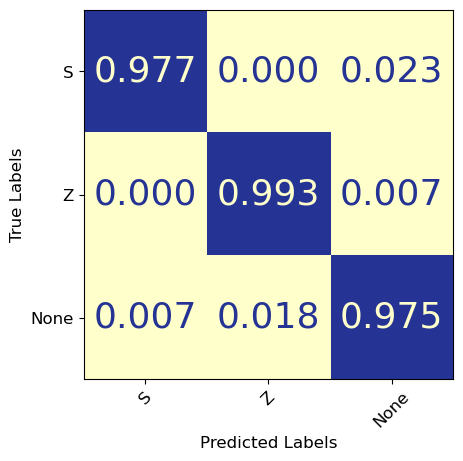

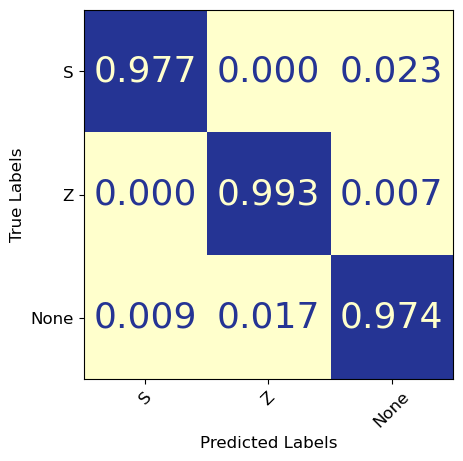

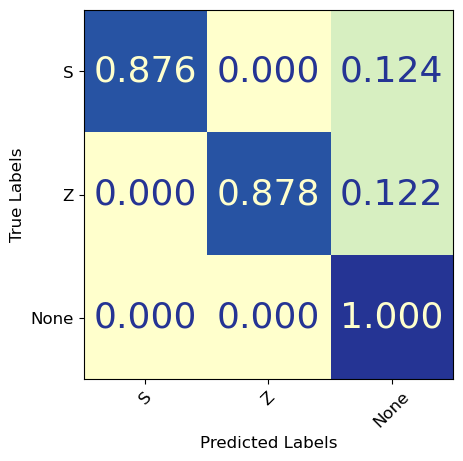

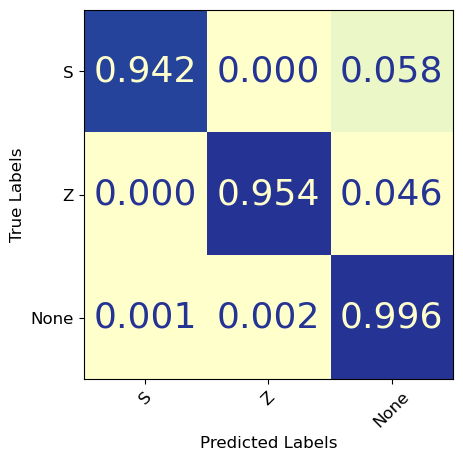

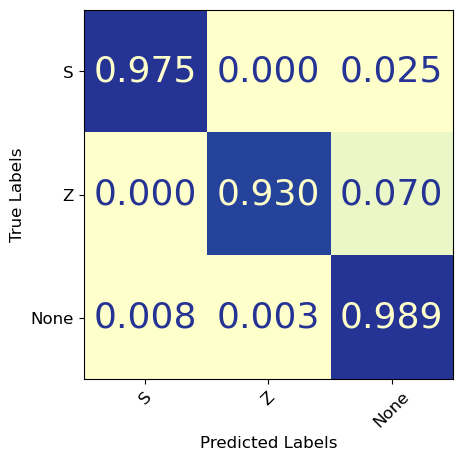

In [24]:
for run in range(0,REPEAT_RUNS):
    
    save_dir = f"{METRICS_PATH}/{MODEL_ID}/version_{run}"
    check_folder(save_dir)

    model = ChiralityClassifier(
        num_classes=(2 if (MODEL_NAME=="jiaresnet50") else 3), #2 for Jia et al version
        model_version=MODEL_NAME,
        optimizer="adamw",
        scheduler  ="steplr",
        lr=0.0001,
        weight_decay=0,
        step_size=5,
        gamma=0.85,
        batch_size=60,
        weights=None,
        model_save_path=f"{save_dir}/model.pt",
        graph_save_path=f"{save_dir}/matrix.png"
    )

    tb_logger = TensorBoardLogger(LOG_PATH, name=MODEL_ID,version=run)
    csv_logger = CSVLogger(LOG_PATH,name=MODEL_ID,version=run)

    trainer = pl.Trainer(
        accelerator=("gpu" if device.type=="cuda" else "cpu"),
        max_epochs=60,
        devices=1,
        logger=([tb_logger,csv_logger] if USE_TENSORBOARD else csv_logger),
        default_root_dir=f'{LOG_PATH}/{MODEL_ID}'
        #profiler="pytorch"
        #callbacks=EarlyStopping(monitor="val_loss", mode="min")
    )

    #compiled_model = torch.compile(model, backend="eager")
    trainer.fit(model,train_dataloaders=datamodule.train_dataloader(),val_dataloaders=datamodule.val_dataloader())

    if RUN_TEST:
        trainer.test(model,dataloaders=datamodule.test_dataloader())
    else:
        trainer.test(model,dataloaders=datamodule.val_dataloader())

    if SAVE_MODEL:
        torch.save(trainer.model.state_dict(), model.model_save_path)